In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

In [8]:
data_cluster = r'C:\Users\piyus\Desktop\CLTV\cleaned_cltv.csv'
dataset_cluster= pd.read_csv(data_cluster)
print(dataset_cluster.head())

   claim_amount  vintage  marital_status  qualification   cltv  Area_Urban  \
0           555        5               0              3   5263           1   
1           625        5               0              2   6064           1   
2           821        5               0              2   8314           1   
3          1498        5               0              3  13995           1   
4           559        5               0              2   4822           1   

   type_of_policy_Silver  policy_b  policy_c  num_policies_More than 1  
0                      1         0         0                         0  
1                      1         0         0                         1  
2                      1         0         0                         1  
3                      1         0         1                         0  
4                      1         0         0                         0  


__Finding number of clustering through elbow method__

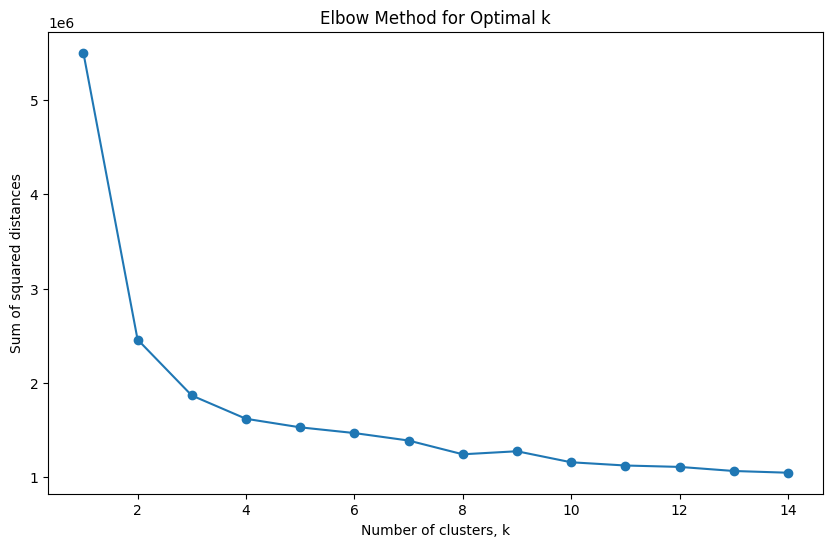

In [9]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import MinMaxScaler

import numpy as np
scaler = MinMaxScaler()

dataset_cluster['cltv'] = scaler.fit_transform(dataset_cluster[['cltv']])
dataset_cluster['claim_amount'] = scaler.fit_transform(dataset_cluster[['claim_amount']])
dataa = dataset_cluster.copy()
# Determine the optimal number of clusters using the elbow method
sse = []
k_candidates = range(1, 15)

for k in k_candidates:
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=100, random_state=42)
    kmeans.fit(dataset_cluster)
    sse.append(kmeans.inertia_)

# Plot SSE (elbow method)
plt.figure(figsize=(10, 6))
plt.plot(k_candidates, sse, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method for Optimal k')
plt.show()

In [10]:
dataa.head()

,claim_amount,vintage,marital_status,qualification,cltv,Area_Urban,type_of_policy_Silver,policy_b,policy_c,num_policies_More than 1
0,0.075122,5,0,3,0.126664,1,1,0,0,0
1,0.084597,5,0,2,0.145941,1,1,0,0,1
2,0.111126,5,0,2,0.200091,1,1,0,0,1
3,0.202761,5,0,3,0.336815,1,1,0,1,0
4,0.075663,5,0,2,0.116050,1,1,0,0,0


__Mini Batch Kmeans - ( SSE and Davies-Bouldin Index Accuracy Metric)__

In [11]:
import numpy as np
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import davies_bouldin_score

n_clusters = 3
batch_size = 1000

kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size, random_state=100)

kmeans.fit(dataset_cluster)

centers_kmeans = kmeans.cluster_centers_
labels_kmeans = kmeans.labels_

if not isinstance(dataset_cluster, pd.DataFrame):
    df_kmeans = pd.DataFrame(dataset_cluster)
else:
    df_kmeans = dataset_cluster.copy()

df_kmeans['Cluster'] = labels_kmeans

# Calculate SSE for each cluster
sse_per_cluster = np.zeros(n_clusters)
for i in range(n_clusters):
    cluster_points = df_kmeans[df_kmeans['Cluster'] == i].drop('Cluster', axis=1)
    distances = np.linalg.norm(cluster_points - centers_kmeans[i], axis=1)
    sse_per_cluster[i] = np.mean(np.square(distances))

# Mean SSE across all clusters
mean_sse = np.mean(sse_per_cluster)

print(f"Mean SSE per cluster: {sse_per_cluster}")
print(f"Mean SSE across all clusters: {mean_sse}")

db_score_kmeans = davies_bouldin_score(df_kmeans.drop('Cluster', axis=1), labels_kmeans)
print(f"Davies-Bouldin Index: {db_score_kmeans}")

sse_kmeans = kmeans.inertia_
print(f"Sum of Squared Error (Total Inertia): {sse_kmeans/1017209}")

Mean SSE per cluster: [1.58609072 2.06503409 1.72811066]
Mean SSE across all clusters: 1.7930784876413595
Davies-Bouldin Index: 1.1877635329802996
Sum of Squared Error (Total Inertia): 1.8316646239224519


__Applied PCA and 2D RERESENTATION__

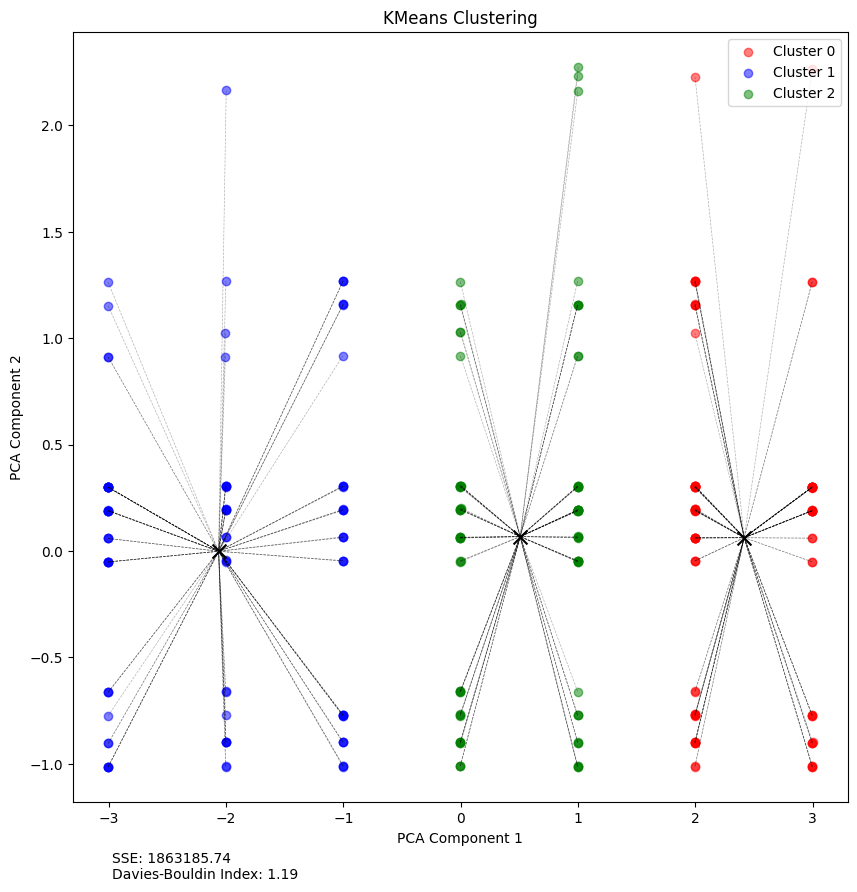

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
dataa_pca = pca.fit_transform(dataset_cluster)

# Sample 100 points from each cluster
samples_per_cluster = 100
colors = ['red', 'blue', 'green']  # Colors for clusters 0, 1, 2

def sample_data(labels):
    sampled_indices = np.hstack([np.random.choice(np.where(labels == i)[0], samples_per_cluster, replace=False) for i in range(3)])
    return dataa_pca[sampled_indices], labels[sampled_indices]

# Sample data for KMeans only
dataa_pca_kmeans, labels_kmeans_sampled = sample_data(labels_kmeans)

# Visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plotting function for 2D
def plot_clusters(ax, data, labels, centroids, title, score_text):
    for i, color in enumerate(colors):
        cluster_data = data[labels == i]

        ax.scatter(cluster_data[:, 0], cluster_data[:, 1], c=color, label=f'Cluster {i}', alpha=0.5)

        centroid = centroids[i]
        ax.scatter(centroid[0], centroid[1], marker='x', s=100, color='k')

        # lines from samples to the centroid
        for point in cluster_data:
            ax.plot([point[0], centroid[0]], [point[1], centroid[1]], 'k--', linewidth=0.5, alpha=0.3)

    ax.set_title(title)
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    plt.legend(loc='upper right')
    ax.text(0.05, -0.1, score_text, transform=ax.transAxes)

# Calculate centroids for the samples in 2D for KMeans
centroids_kmeans_pca = np.array([dataa_pca_kmeans[labels_kmeans_sampled == i].mean(axis=0) for i in range(3)])

# Plot for KMeans only
plot_clusters(ax, dataa_pca_kmeans, labels_kmeans_sampled, centroids_kmeans_pca, 
              'KMeans Clustering', 
              'SSE: {:.2f}\nDavies-Bouldin Index: {:.2f}'.format(sse_kmeans, db_score_kmeans))

plt.show()
